<a href="https://colab.research.google.com/github/Gleibi/Cool_Project_Stock_Price_Prediction/blob/main/Prediction/model_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install yfinance

# Выгрузка и подготовка данных

In [2]:
import yfinance as yf

In [3]:
aapl = yf.Ticker('AAPL')

hist = aapl.history(period='10y')

In [4]:
hist = hist.asfreq('D')
hist.fillna(method='bfill', inplace=True)

hist['close_shift'] =  hist.Close.shift(1)
hist['target'] = hist.Close - hist.close_shift

hist = hist[~hist.close_shift.isna()]

In [5]:
hist.isnull().values.any()

False

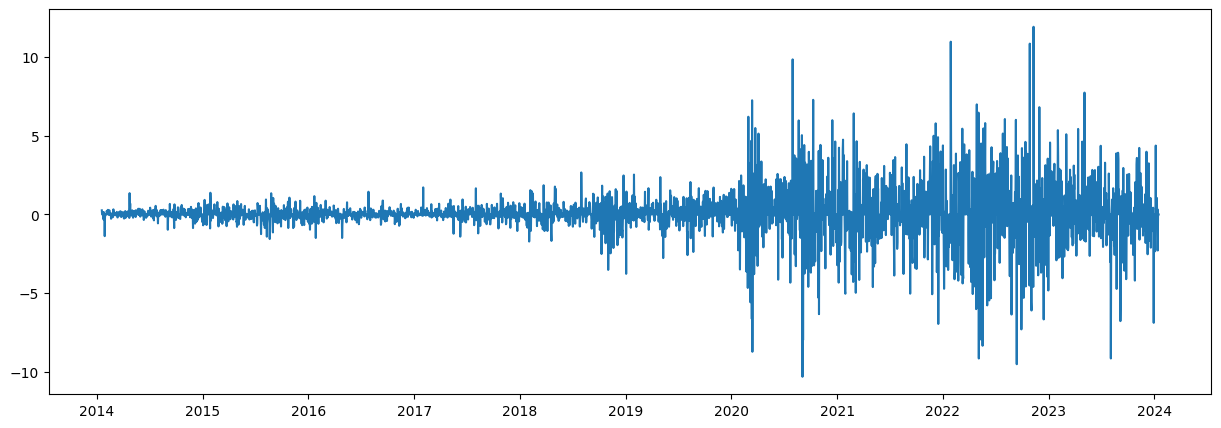

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(hist.target)
plt.show()

# Все нужные импорты

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor
from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import ParameterGrid

from datetime import date, timedelta
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
import seaborn as sns

# Бейзлайн
Нужно выбрать то, с чем сравнивать модели. Возьмем константу, например, среднее изменение цены за прошлую неделю.

In [8]:
hist.reset_index(inplace=True)

hist['Date'] = hist.Date.dt.date

hist.set_index('Date', inplace=True)

In [9]:
start = date.today() - timedelta(days=7)

train = hist[hist.index <= start]
test = hist[hist.index > start]

In [10]:
y_train = train.target
y_test = test.target

In [11]:
results = dict()

y_pred = train[train.index >= date.today() - timedelta(days=14)].target.mean()

baseline = [y_pred for _ in range(y_test.shape[0])]

results['baseline'] = {
    'MAPE': round(mape(y_test, baseline), 3),
    'RMSE': round(mse(y_test, baseline, squared=True), 3),
    'MAE':  round(mae(y_test, baseline), 3),
}

In [12]:
results

{'baseline': {'MAPE': 154812096184320.5, 'RMSE': 1.016, 'MAE': 0.583}}

# Модели
## Простое экспоненциальное сглаживание

In [13]:
model = SimpleExpSmoothing(y_train).fit()

y_pred_ses = model.forecast(len(y_test))

results['ses'] = {
    'MAPE': round(mape(y_test, y_pred_ses), 3),
    'RMSE': round(mse(y_test, y_pred_ses, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_ses), 3),
}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [14]:
results

{'baseline': {'MAPE': 154812096184320.5, 'RMSE': 1.016, 'MAE': 0.583},
 'ses': {'MAPE': 142917214877857.38, 'RMSE': 1.01, 'MAE': 0.579}}

## Хольт

In [15]:
holt_params = {
  'exponential': False,
  'damped_trend': False
}

model = Holt(y_train, **holt_params).fit()

y_pred_holt = model.forecast(len(y_test))

results['holt'] = {
    'MAPE': round(mape(y_test, y_pred_holt), 3),
    'RMSE': round(mse(y_test, y_pred_holt, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_holt), 3),
}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [16]:
results

{'baseline': {'MAPE': 154812096184320.5, 'RMSE': 1.016, 'MAE': 0.583},
 'ses': {'MAPE': 142917214877857.38, 'RMSE': 1.01, 'MAE': 0.579},
 'holt': {'MAPE': 1107830354943177.6, 'RMSE': 0.783, 'MAE': 0.708}}

## Хольт-винтерс

In [17]:
hw_params = {
  'trend': 'add',
  'seasonal': 'add',
  'damped_trend': False
}

model = ExponentialSmoothing(y_train, **hw_params).fit()

y_pred_hw = model.forecast(len(y_test))

results['hw'] = {
    'MAPE': round(mape(y_test, y_pred_hw), 3),
    'RMSE': round(mse(y_test, y_pred_hw, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_hw), 3),
}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [18]:
results

{'baseline': {'MAPE': 154812096184320.5, 'RMSE': 1.016, 'MAE': 0.583},
 'ses': {'MAPE': 142917214877857.38, 'RMSE': 1.01, 'MAE': 0.579},
 'holt': {'MAPE': 1107830354943177.6, 'RMSE': 0.783, 'MAE': 0.708},
 'hw': {'MAPE': 192774627915861.1, 'RMSE': 1.058, 'MAE': 0.584}}

## Prophet

In [19]:
args_prophet = {
    'weekly_seasonality': True,
    # 'yearly_seasonality': True,
    'daily_seasonality': True,
    # 'holidays_prior_scale': 2,
    'seasonality_mode': 'additive'
}

data_for_model = y_train.reset_index()
data_for_model.rename(columns={'Date':'ds', 'target': 'y'}, inplace=True)

model = Prophet(**args_prophet)
model.add_country_holidays(country_name='US')

model.fit(data_for_model)

future = model.make_future_dataframe(y_test.shape[0], freq='D', include_history = False)
forecast = model.predict(future)
y_pred_prophet = forecast.yhat

results['fbprophet'] = {
    'MAPE': round(mape(y_test, y_pred_prophet), 3),
    'RMSE': round(mse(y_test, y_pred_prophet, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_prophet), 3),
}

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwn8wq6hh/9szrpvdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwn8wq6hh/_zkkoo63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56569', 'data', 'file=/tmp/tmpwn8wq6hh/9szrpvdh.json', 'init=/tmp/tmpwn8wq6hh/_zkkoo63.json', 'output', 'file=/tmp/tmpwn8wq6hh/prophet_model1scsijct/prophet_model-20240117121118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:11:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
results

{'baseline': {'MAPE': 154812096184320.5, 'RMSE': 1.016, 'MAE': 0.583},
 'ses': {'MAPE': 142917214877857.38, 'RMSE': 1.01, 'MAE': 0.579},
 'holt': {'MAPE': 1107830354943177.6, 'RMSE': 0.783, 'MAE': 0.708},
 'hw': {'MAPE': 192774627915861.1, 'RMSE': 1.058, 'MAE': 0.584},
 'fbprophet': {'MAPE': 205599523079719.28, 'RMSE': 1.037, 'MAE': 0.585}}

## Gradient Boosting

In [21]:
def create_time_feature(df):

    df['dayofmonth'] = df['Date'].dt.day.apply(str)
    df['dayofweek'] = df['Date'].dt.dayofweek.apply(str)
    df['quarter'] = df['Date'].dt.quarter.apply(str)
    df['month'] = df['Date'].dt.month.apply(str)
    df['year'] = df['Date'].dt.year.apply(str)
    df['dayofyear'] = df['Date'].dt.dayofyear.apply(str)
    df['weekofyear'] = df['Date'].dt.isocalendar().week.apply(str)

    return df

In [22]:
df_gb_features = hist.copy()

for w in [3, 5, 10, 30]:
  df_gb_features[f'rolling_{w}'] = df_gb_features.target.rolling(window=w).mean().shift(1)

start_date = df_gb_features.index.min() + timedelta(days=30) # чтобы не было пропусков в новых фичах

df_gb_features = df_gb_features[df_gb_features.index > start_date]

df_gb_features.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,rolling_3,rolling_5,rolling_10,rolling_30
Date,,,,,,,,,,,,,
2014-02-18,17.197819,17.361291,17.185534,17.197504,260251600.0,0.0,0.0,17.197504,0.000000,0.020998,0.063437,0.082871,0.000197
2014-02-19,17.158443,17.225849,16.830866,16.925989,313768000.0,0.0,0.0,17.197504,-0.271515,0.000000,0.009828,0.053546,0.000197
2014-02-20,16.788028,16.914335,16.662351,16.730072,305858000.0,0.0,0.0,16.925989,-0.195917,-0.090505,-0.041704,0.026395,-0.008854
2014-02-21,16.781732,16.837799,16.523765,16.544239,278784800.0,0.0,0.0,16.730072,-0.185833,-0.155811,-0.093486,0.006803,-0.015385
2014-02-22,16.478084,16.691324,16.455090,16.616673,288909600.0,0.0,0.0,16.544239,0.072433,-0.217755,-0.130653,-0.033734,-0.024126


In [25]:
# Microsoft
msft = yf.Ticker('MSFT')

microsoft_hist = msft.history('10y')

# SONY
sony = yf.Ticker('SONY')

sony_hist = sony.history('10y')

# Google
googl = yf.Ticker('GOOGl')

google_hist = googl.history('10y')

In [27]:
def normalize_hist(hist, col_name):

  hist = hist.asfreq('D')
  hist.fillna(method='bfill', inplace=True)

  hist['close_shift'] =  hist.Close.shift(2)
  hist[f'{col_name}_target'] = hist.Close - hist.close_shift

  hist = hist[~hist.close_shift.isna()]

  hist.reset_index(inplace=True)

  hist['Date'] = hist.Date.dt.date

  hist.set_index('Date', inplace=True)

  return hist

microsoft_hist = normalize_hist(microsoft_hist, 'microsoft')
sony_hist = normalize_hist(sony_hist, 'sony')
google_hist = normalize_hist(google_hist, 'google')

google_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,google_target
Date,,,,,,,,,
2014-01-21,29.052301,29.129129,28.811312,29.121622,79116804.0,0.0,0.0,29.121622,0.000000
2014-01-22,29.194445,29.226477,29.000502,29.154655,62793144.0,0.0,0.0,29.121622,0.033033
2014-01-23,29.029030,29.091341,28.888138,29.031532,77886036.0,0.0,0.0,29.121622,-0.090090
2014-01-24,28.804054,28.867619,28.103104,28.123875,155544300.0,0.0,0.0,29.154655,-1.030781
2014-01-25,28.180681,28.190691,27.083834,27.558308,173969856.0,0.0,0.0,29.031532,-1.473225


In [28]:
df_gb_features['microsoft_target'] = microsoft_hist.microsoft_target
df_gb_features['sony_target'] = sony_hist.sony_target
df_gb_features['google_target'] = google_hist.google_target
df_gb_features.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,rolling_3,rolling_5,rolling_10,rolling_30,microsoft_target,sony_target,google_target
Date,,,,,,,,,,,,,,,,
2014-02-18,17.197819,17.361291,17.185534,17.197504,260251600.0,0.0,0.0,17.197504,0.000000,0.020998,0.063437,0.082871,0.000197,0.000000,0.000000,0.000000
2014-02-19,17.158443,17.225849,16.830866,16.925989,313768000.0,0.0,0.0,17.197504,-0.271515,0.000000,0.009828,0.053546,0.000197,0.076359,-0.270000,-0.213713
2014-02-20,16.788028,16.914335,16.662351,16.730072,305858000.0,0.0,0.0,16.925989,-0.195917,-0.090505,-0.041704,0.026395,-0.008854,0.279970,-0.170000,-0.169418
2014-02-21,16.781732,16.837799,16.523765,16.544239,278784800.0,0.0,0.0,16.730072,-0.185833,-0.155811,-0.093486,0.006803,-0.015385,0.398733,0.050001,0.036285
2014-02-22,16.478084,16.691324,16.455090,16.616673,288909600.0,0.0,0.0,16.544239,0.072433,-0.217755,-0.130653,-0.033734,-0.024126,-0.050898,0.230000,0.210211


In [29]:
df_gb_features = df_gb_features.reset_index()

df_gb_features.Date = pd.to_datetime(df_gb_features.Date)

df_gb_features = create_time_feature(df_gb_features)

In [32]:
df_gb_features = df_gb_features[~df_gb_features.microsoft_target.isna()]

In [33]:
df_gb_features.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,...,microsoft_target,sony_target,google_target,dayofmonth,dayofweek,quarter,month,year,dayofyear,weekofyear
0,2014-02-18,17.197819,17.361291,17.185534,17.197504,260251600.0,0.0,0.0,17.197504,0.000000,...,0.000000,0.000000,0.000000,18,1,1,2,2014,49,8
1,2014-02-19,17.158443,17.225849,16.830866,16.925989,313768000.0,0.0,0.0,17.197504,-0.271515,...,0.076359,-0.270000,-0.213713,19,2,1,2,2014,50,8
2,2014-02-20,16.788028,16.914335,16.662351,16.730072,305858000.0,0.0,0.0,16.925989,-0.195917,...,0.279970,-0.170000,-0.169418,20,3,1,2,2014,51,8
3,2014-02-21,16.781732,16.837799,16.523765,16.544239,278784800.0,0.0,0.0,16.730072,-0.185833,...,0.398733,0.050001,0.036285,21,4,1,2,2014,52,8
4,2014-02-22,16.478084,16.691324,16.455090,16.616673,288909600.0,0.0,0.0,16.544239,0.072433,...,-0.050898,0.230000,0.210211,22,5,1,2,2014,53,8


In [34]:
cols = ['Open', 'High', 'Low', 'Close']

for col in cols:
  df_gb_features[f'{col}_prev'] = df_gb_features[col].shift(1)
  # df_gb_features[f'{col}_prev_week'] = df_gb_features[col].shift(7)
  # df_gb_features[f'{col}_prev_month'] = df_gb_features[col].shift(30)


df_gb_features = df_gb_features[~df_gb_features['Open_prev'].isna()]

In [35]:
from sklearn.preprocessing import StandardScaler

# cols = ['rolling_3', 'rolling_5',
#        'rolling_10', 'rolling_30', 'samsung_target', 'sony_target',
#        'xiaomi_target', 'Open_prev', 'Open_prev_week',
#        'Open_prev_month', 'High_prev', 'High_prev_week', 'High_prev_month',
#        'Low_prev', 'Low_prev_week', 'Low_prev_month', 'Close_prev',
#        'Close_prev_week', 'Close_prev_month']
cols = ['target', 'rolling_3', 'rolling_5',
       'rolling_10', 'rolling_30', 'microsoft_target', 'sony_target',
       'google_target', 'dayofmonth', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'weekofyear', 'Open_prev', 'High_prev',
       'Low_prev', 'Close_prev']

scaler = StandardScaler()

scaler.fit(df_gb_features[cols])
df_gb_features[cols] = scaler.transform(df_gb_features[cols])
df_gb_features.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,...,dayofweek,quarter,month,year,dayofyear,weekofyear,Open_prev,High_prev,Low_prev,Close_prev
1,2014-02-19,17.158443,17.225849,16.830866,16.925989,313768000.0,0.0,0.0,17.197504,-0.221805,...,-0.5,-1.368277,-1.331734,-1.603552,-1.281677,-1.254388,-1.052754,-1.053152,-1.050003,-1.053089
2,2014-02-20,16.788028,16.914335,16.662351,16.730072,305858000.0,0.0,0.0,16.925989,-0.168993,...,0.0,-1.368277,-1.331734,-1.603552,-1.272145,-1.254388,-1.053445,-1.055504,-1.056295,-1.057851
3,2014-02-21,16.781732,16.837799,16.523765,16.544239,278784800.0,0.0,0.0,16.730072,-0.161948,...,0.5,-1.368277,-1.331734,-1.603552,-1.262614,-1.254388,-1.059952,-1.060914,-1.059285,-1.061288
4,2014-02-22,16.478084,16.691324,16.455090,16.616673,288909600.0,0.0,0.0,16.544239,0.018474,...,1.0,-1.368277,-1.331734,-1.603552,-1.253082,-1.254388,-1.060062,-1.062244,-1.061744,-1.064547
5,2014-02-23,16.478084,16.691324,16.455090,16.616673,288909600.0,0.0,0.0,16.616673,-0.032127,...,1.5,-1.368277,-1.331734,-1.603552,-1.243551,-1.254388,-1.065396,-1.064788,-1.062963,-1.063277


In [36]:
start = date.today() - timedelta(days=7)

cols = ['target', 'rolling_3', 'rolling_5',
       'rolling_10', 'rolling_30', 'microsoft_target', 'sony_target',
       'google_target', 'dayofmonth', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'weekofyear', 'Open_prev', 'High_prev',
       'Low_prev', 'Close_prev']

df_gb_features.Date = df_gb_features.Date.dt.date

df_train = df_gb_features[df_gb_features.Date <= start][cols]
y_train = df_train.target

df_train.drop(columns='target', inplace=True)

df_test = df_gb_features[df_gb_features.Date > start][cols]
y_test = df_test.target

df_test.drop(columns='target', inplace=True)

gb_params = {
    'n_estimators': 10000,
    'loss': 'squared_error',
    'learning_rate': 0.05,
    'random_state': 12,
    'verbose': 1,
    'n_iter_no_change': 100
}

model = GradientBoostingRegressor(**gb_params)
model.fit(df_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9634            3.13m
         2           0.9360            3.33m
         3           0.9111            3.36m
         4           0.8883            3.32m
         5           0.8675            3.28m
         6           0.8482            3.25m
         7           0.8307            3.24m
         8           0.8138            3.22m
         9           0.7983            3.22m
        10           0.7842            3.20m
        20           0.6812            3.21m
        30           0.6257            3.60m
        40           0.5881            3.67m
        50           0.5615            4.06m
        60           0.5424            4.34m
        70           0.5272            4.61m
        80           0.5109            4.79m
        90           0.4984            4.93m
       100           0.4887            5.01m
       200           0.4028            3.75m


GradientBoostingRegressor(learning_rate=0.05, n_estimators=10000,
                          n_iter_no_change=100, random_state=12, verbose=1)

In [37]:
y_pred_gb = model.predict(df_test)

In [38]:
results['gradient_boosting'] = {
    'MAPE': round(mape(y_test, y_pred_gb), 3),
    'RMSE': round(mse(y_test, y_pred_gb, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_gb), 3),
}

In [ ]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4}}

## Линейная регрессия

In [41]:
model = LinearRegression()
model.fit(df_train, y_train)

LinearRegression()

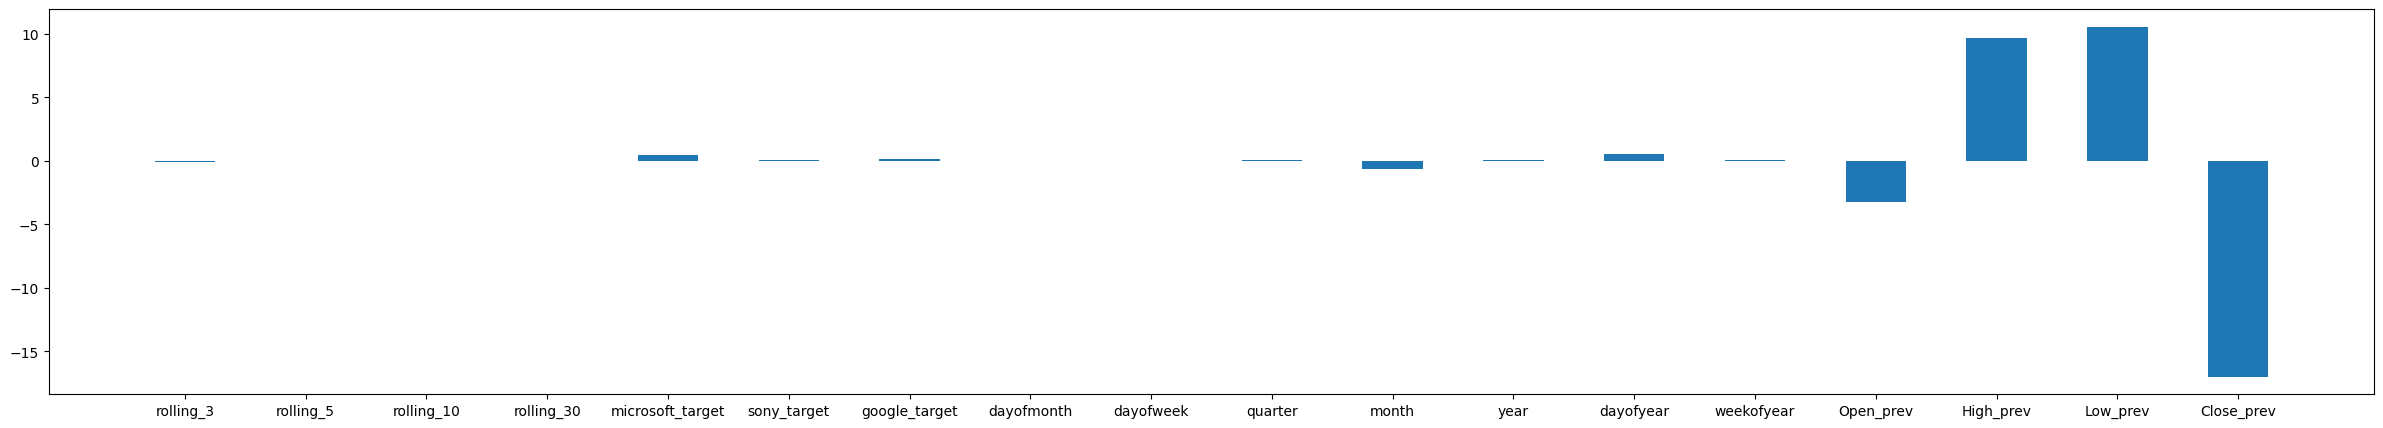

In [42]:
plt.figure(figsize=(30, 5))
plt.bar(x=df_train.columns, height=model.coef_, width=.5)
plt.show()

<Axes: >

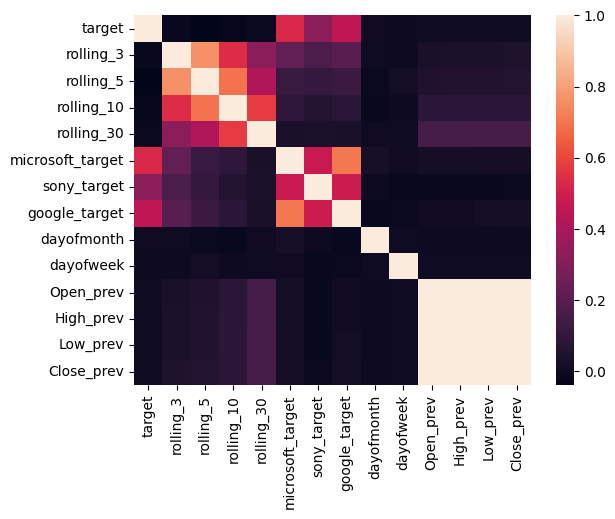

In [44]:
cols = ['target', 'rolling_3', 'rolling_5',
       'rolling_10', 'rolling_30', 'microsoft_target', 'sony_target',
       'google_target', 'dayofmonth', 'dayofweek', 'Open_prev', 'High_prev',
       'Low_prev', 'Close_prev']

sns.heatmap(df_gb_features[cols].corr())

<ipython-input-288-944a1f5bda24>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_gb_features[cols].corr())


<Axes: >

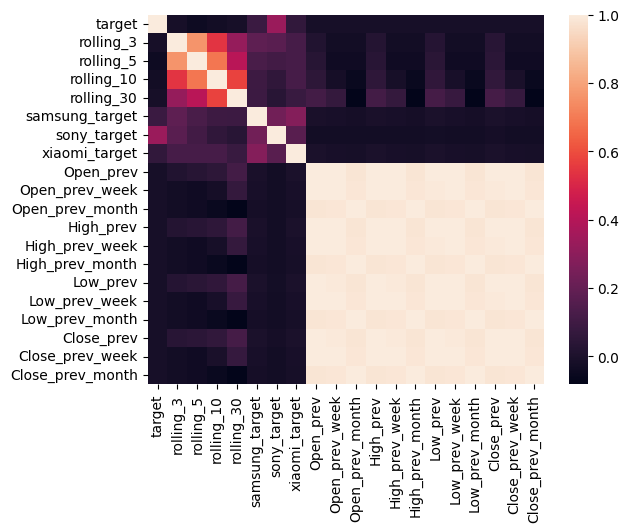

In [ ]:
sns.heatmap(df_gb_features[cols].corr())

In [ ]:
cols = ['rolling_3', 'rolling_30', 'samsung_target', 'sony_target',
       'xiaomi_target', 'Close_prev']

model = LinearRegression()
model.fit(df_train[cols], y_train)

LinearRegression()

In [ ]:
y_pred_lr = model.predict(df_test[cols])

In [ ]:
results['linear_regression'] = {
    'MAPE': round(mape(y_test, y_pred_lr), 3),
    'RMSE': round(mse(y_test, y_pred_lr, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_lr), 3),
}

In [ ]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4},
 'linear_regression': {'MAPE': 2.148, 'RMSE': 0.546, 'MAE': 0.544}}

In [ ]:
model = Ridge()
model.fit(df_train[cols], y_train)

Ridge()

In [ ]:
y_pred_lr_ridge = model.predict(df_test[cols])

In [ ]:
results['ridge'] = {
    'MAPE': round(mape(y_test, y_pred_lr_ridge), 3),
    'RMSE': round(mse(y_test, y_pred_lr_ridge, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_lr_ridge), 3),
}

In [ ]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4},
 'linear_regression': {'MAPE': 2.148, 'RMSE': 0.546, 'MAE': 0.544},
 'ridge': {'MAPE': 2.147, 'RMSE': 0.545, 'MAE': 0.544}}

In [ ]:
model = Lasso()
model.fit(df_train[cols], y_train)

Lasso()

In [ ]:
y_pred_lr_lasso = model.predict(df_test[cols])

results['lasso'] = {
    'MAPE': round(mape(y_test, y_pred_lr_lasso), 3),
    'RMSE': round(mse(y_test, y_pred_lr_lasso, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_lr_lasso), 3),
}

In [ ]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4},
 'linear_regression': {'MAPE': 2.148, 'RMSE': 0.546, 'MAE': 0.544},
 'ridge': {'MAPE': 2.147, 'RMSE': 0.545, 'MAE': 0.544},
 'lasso': {'MAPE': 1.0, 'RMSE': 0.119, 'MAE': 0.317}}

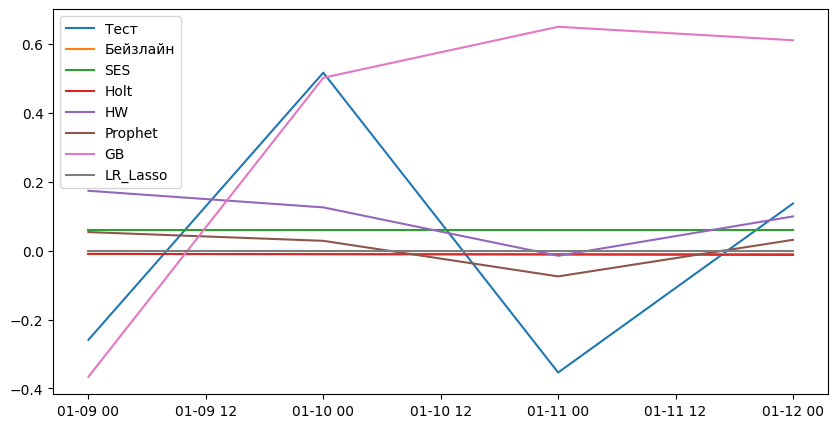

In [ ]:
legend = ['Тест', 'Бейзлайн', 'SES', 'Holt', 'HW', 'Prophet', 'GB', 'LR_Lasso']

plt.figure(figsize=(10, 5))

plt.plot(test.index, y_test)
plt.plot(test.index, baseline)
plt.plot(test.index, y_pred_ses)
plt.plot(test.index, y_pred_holt)
plt.plot(test.index, y_pred_hw)
plt.plot(test.index, y_pred_prophet)
plt.plot(test.index, y_pred_gb)
# plt.plot(test.index, y_pred_lr)
# plt.plot(test.index, y_pred_lr_ridge)
plt.plot(test.index, y_pred_lr_lasso)

plt.legend(legend)